# Cart pole problem


https://github.com/JackFurby/CartPole-v0.git



                    GNU GENERAL PUBLIC LICENSE
                       Version 3, 29 June 2007

 Copyright (C) 2007 Free Software Foundation, Inc. <https://fsf.org/>
 Everyone is permitted to copy and distribute verbatim copies
 of this license document, but changing it is not allowed.

Run: 0 Average: 17.0 Min: 17 Max: 17
Run: 100 Average: 24.0 Min: 10 Max: 75
Run: 200 Average: 35.09 Min: 8 Max: 135
Run: 300 Average: 57.32 Min: 12 Max: 149
Run: 400 Average: 76.35 Min: 9 Max: 200
Run: 500 Average: 105.62 Min: 16 Max: 200
Run: 600 Average: 137.31 Min: 75 Max: 196
Run: 700 Average: 140.28 Min: 95 Max: 200
Run: 800 Average: 159.1 Min: 100 Max: 200
Run: 900 Average: 166.15 Min: 109 Max: 200


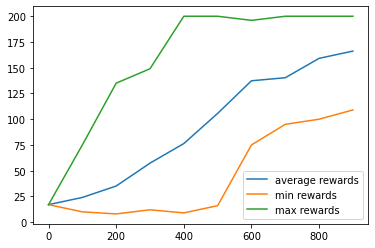

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('CartPole-v0')

# How much new info will override old info. 0 means nothing is learned, 1 means only most recent is considered, old knowledge is discarded
LEARNING_RATE = 0.5
# Between 0 and 1, mesue of how much we carre about future reward over immedate reward
DISCOUNT = 0.95
RUNS = 1000  # Number of iterations run
SHOW_EVERY = 100  # How oftern the current solution is rendered
UPDATE_EVERY = 100  # How oftern the current progress is recorded

# Exploration settings
epsilon = 1  # not a constant, going to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = RUNS // 2
epsilon_decay_value = epsilon / (END_EPSILON_DECAYING - START_EPSILON_DECAYING)


# Create bins and Q table
def create_bins_and_q_table():
	# env.observation_space.high
	# [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]
	# env.observation_space.low
	# [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]

	# remove hard coded Values when I know how to

	numBins = 20
	obsSpaceSize = len(env.observation_space.high)

	# Get the size of each bucket
	bins = [
		np.linspace(-4.8, 4.8, numBins),
		np.linspace(-4, 4, numBins),
		np.linspace(-.418, .418, numBins),
		np.linspace(-4, 4, numBins)
	]

	qTable = np.random.uniform(low=-2, high=0, size=([numBins] * obsSpaceSize + [env.action_space.n]))

	return bins, obsSpaceSize, qTable


# Given a state of the enviroment, return its descreteState index in qTable
def get_discrete_state(state, bins, obsSpaceSize):
	stateIndex = []
	for i in range(obsSpaceSize):
		stateIndex.append(np.digitize(state[i], bins[i]) - 1) # -1 will turn bin into index
	return tuple(stateIndex)


bins, obsSpaceSize, qTable = create_bins_and_q_table()

previousCnt = []  # array of all scores over runs
metrics = {'ep': [], 'avg': [], 'min': [], 'max': []}  # metrics recorded for graph

for run in range(RUNS):
	discreteState = get_discrete_state(env.reset(), bins, obsSpaceSize)
	done = False  # has the enviroment finished?
	cnt = 0  # how may movements cart has made

	while not done:
		if run % SHOW_EVERY == 0:
			env.render()  # if running RL comment this out

		cnt += 1
		# Get action from Q table
		if np.random.random() > epsilon:
			action = np.argmax(qTable[discreteState])
		# Get random action
		else:
			action = np.random.randint(0, env.action_space.n)
		newState, reward, done, _ = env.step(action)  # perform action on enviroment

		newDiscreteState = get_discrete_state(newState, bins, obsSpaceSize)

		maxFutureQ = np.max(qTable[newDiscreteState])  # estimate of optiomal future value
		currentQ = qTable[discreteState + (action, )]  # old value

		# pole fell over / went out of bounds, negative reward
		if done and cnt < 200:
			reward = -375

		# formula to caculate all Q values
		newQ = (1 - LEARNING_RATE) * currentQ + LEARNING_RATE * (reward + DISCOUNT * maxFutureQ)
		qTable[discreteState + (action, )] = newQ  # Update qTable with new Q value

		discreteState = newDiscreteState

	previousCnt.append(cnt)

	# Decaying is being done every run if run number is within decaying range
	if END_EPSILON_DECAYING >= run >= START_EPSILON_DECAYING:
		epsilon -= epsilon_decay_value

	# Add new metrics for graph
	if run % UPDATE_EVERY == 0:
		latestRuns = previousCnt[-UPDATE_EVERY:]
		averageCnt = sum(latestRuns) / len(latestRuns)
		metrics['ep'].append(run)
		metrics['avg'].append(averageCnt)
		metrics['min'].append(min(latestRuns))
		metrics['max'].append(max(latestRuns))
		print("Run:", run, "Average:", averageCnt, "Min:", min(latestRuns), "Max:", max(latestRuns))


env.close()

# Plot graph
plt.plot(metrics['ep'], metrics['avg'], label="average rewards")
plt.plot(metrics['ep'], metrics['min'], label="min rewards")
plt.plot(metrics['ep'], metrics['max'], label="max rewards")
plt.legend(loc=4)
plt.show()